# ~ PoC AI Pool 2025 ~
- ## Day 3: Deep Learning
    - ### Module 2: Convolutional Neural Network
-----------

## Minst

Well done, you've arrived here ! You now understand key concepts of neural networks and how they are trained, but you haven't really created one yet...
Don't worry this task will guide you in recreating a neural network trained to detect any handwritten digit on a 28 by 28 pixel image !

Your will start by setup the dataset, your model and at the end, play with it ! 

In [46]:
#Just import the necessary libraries

import time
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt


#For the model don't forget
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

### Part - 1 Prepare the data 

before actually create a neural network we need to preparate our data that we will fit to your model,

remember ***THE MOST important in machine learning is the quality of the data*** and not really the model....

your goal here is to specify how we want the data, this can be process by initialise a data and transform it in a [tensor](https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html) and normalize it if you want. you can check the doc of transform [here](https://pytorch.org/vision/0.9/transforms.html).

In [47]:
transform_train = transforms.Compose([
    transforms.RandomRotation(10),           # Rotation aléatoire ±10°
    transforms.RandomAffine(0, translate=(0.1, 0.1)),  # Translation
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Normalisation MNIST
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)
eval_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)

print(f"Len train dataset : {len(train_set)}")
print(f"Len test  dataset : {len(eval_set)}")

Len train dataset : 60000
Len test  dataset : 10000


You will say why whe created two dataset ? 

It's because one will be for the training of the model and the other for evaluate this one by passing data he never seen, to see if the model didn't overfit the data.

To understand what's inside this code you can try below to visualise some of the examples !

***Don't hesitate to change the NUMBER_OF_ELEMENTS enum to see mutliples examples or no***

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.8214867].


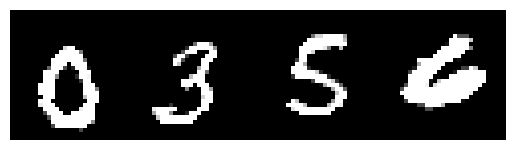

Labels : 0; 3; 5; 6;


In [48]:
# Visualisation of some element of the dataset you can change the number if you want
NUMBER_OF_ELEMENTS = 4

def imshow(img):
    # img = img * 0.5 + 0.5  # Denormalisation if you have normalised the data
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.axis('off')
    plt.show()

train_loader_vis = torch.utils.data.DataLoader(train_set, batch_size=NUMBER_OF_ELEMENTS, shuffle=True)

# Random image 
dataiter = iter(train_loader_vis)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print('Labels :', ' '.join(f'{labels[j].item()};' for j in range(NUMBER_OF_ELEMENTS)))

We can also look at different attributes like the number of images in the dataset, the size of each image or the label of an image.

In [49]:
image, label = train_set[0]

print("image :", image) # pixels value if you want to see the matrix
print("-"*60)
print("image shape :", image.shape) # pixels value
print("label :", label) # Number represented in the image 


image : tensor([[[-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           1.8032, -0.0933,  1.6887,  2.8215,  2.7197,  1.1923, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.3860, -0.1951, -0.

As you can see, we have images **28 pixels high and 28 pixels wide**, with **one channel** (grayscale !).

These images represent a number from 0 to 9, we have **10 different labels** (or 10 different possible output).\
The first picture represents a 5, therefore its label is 5.

---
## Batch-Size

Did you remember when we talk about batch and parallelization of multiple example with torch ? This is very important here !

**60,000** is a lot of images to process one by one, to make it easier for our model to process this data while training we are going to use ``batch_size``.

for one who forget , ``batch_size`` is a hyperparameter that defines the number of samples to work through before updating the internal model parameters. In other words, before calculating the error and apply backpropagation after each image, if our batch size is 64 we will go through 64 images before doing it. **This improves the learning of our AI** by **applying the backpropagation on the error average.**

As in the previous notebook we will use a [**``dataloader``**](https://pytorch.org/docs/stable/data.html), this time we don't need to redefine a ``Dataset`` class since we are using a ``builtin`` dataset in ``torchvision``.

Remember to specify that you use the ``train_set`` and you want a ``batch_size`` of ``64`` and also ``shuffle`` it.

In [50]:
#TODO : Define the batch size
import torch.utils.data.dataloader


BATCH_SIZE = 128

train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

# assert len(train_loader) == 938, "Your train loader is not well implemented, remember that the batch size is 64"

batch = next(iter(train_loader)) # obtain the first batch
images, labels = batch
print("image shape :", images.shape)
print("labels shape :", labels.shape)

image shape : torch.Size([128, 1, 28, 28])
labels shape : torch.Size([128])


We now have `938` lots containing `64` images each (and their equivalent labels).\
This will **drastically decrease our training time** because with one backward propagation, 64 images are processed.


> Pytorch is built to be used with batch, it is thus quite simple to implement it in our code. 

*you can try after to change your batch and see the difference in the learning (remove the assert for test it)* !

In [51]:
#TODO: Also load the test set with the same batch_size...

eval_loader = torch.utils.data.DataLoader(eval_set, batch_size=BATCH_SIZE, shuffle=True)

# assert len(eval_loader) == 157, "Your eval loader is not well implemented"

## The Model!

And your moment has arrived!

I’m sure you’ve been eagerly anticipating this step, and now you’re ready to build your very first real neural network, complete with a more complex architecture.

A quick tip for working with PyTorch: today’s task is a classification problem, as we’ve defined specific output labels. For this, we’ll be using the **[cross-entropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)** loss function. (Remember, yesterday you used the **[binary cross-entropy](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html)** loss with logistic regression, since the output was restricted to just 0 or 1.)

*Don't hesistate to jump at the end of the torch introduction as helping you for initialize the model and train it !*

IF you encounter difficulties to create your model, at the end of this notebook there is a pseudo code of the architecture as to help you to create the model, but try to do it alone ! (with everything you see before)

In [52]:
#TODO : Define the learning rate
LEARNING_RATE = 0.001


class MNISTModel(nn.Module):
    def __init__(self):
        super(MNISTModel, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        # Deuxième bloc avec skip connection
        self.conv2a = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2a = nn.BatchNorm2d(64)
        self.conv2b = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2b = nn.BatchNorm2d(64)
        
        # Troisième bloc
        self.conv3a = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3a = nn.BatchNorm2d(128)
        self.conv3b = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn3b = nn.BatchNorm2d(128)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout_conv = nn.Dropout2d(0.25)
        
        # Fully connected
        self.fc1 = nn.Linear(128 * 7 * 7, 512)
        self.bn_fc1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn_fc2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 10)
        
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

        self.loss = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters(), lr=LEARNING_RATE)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', factor=0.5, patience=3, verbose=True
        )        
        # Device choice 
        if torch.cuda.is_available():
            self.device = torch.device('cuda')
        elif torch.backends.mps.is_available():
            self.device = torch.device('mps')
        else:
            self.device = torch.device('cpu')
        print(f"Device : {self.device}")
        self.to(self.device)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.dropout_conv(x)
        
        # Bloc 2 (résiduel)
        identity = x
        x = self.relu(self.bn2a(self.conv2a(x)))
        x = self.bn2b(self.conv2b(x))
        # Skip connection (adapter les dimensions si nécessaire)
        if identity.shape[1] != x.shape[1]:
            identity = nn.Conv2d(32, 64, kernel_size=1).to(x.device)(identity)
        x = self.relu(x + identity)
        x = self.pool(x)
        x = self.dropout_conv(x)
        
        # Bloc 3
        x = self.relu(self.bn3a(self.conv3a(x)))
        x = self.relu(self.bn3b(self.conv3b(x)))
        
        # FC layers
        x = x.view(-1, 128 * 7 * 7)
        x = self.relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn_fc2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x


    def train_model(self, epochs, train_loader):
        self.train()

        for epoch in range(epochs):
            start_time = time.time()
            running_loss = 0.0
            total_batches = 0

            for i, data in enumerate(train_loader):
                inputs, labels = data
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                
                self.optimizer.zero_grad()
                outputs = self(inputs)
                loss = self.loss(outputs, labels)
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()
                total_batches += 1

                if (i + 1) % 8 == 0 or (i + 1) == len(train_loader):
                    print(f"\rEpochs {epoch + 1}/{epochs} | Lot {i + 1}/{len(train_loader)} | Loss : {loss.item():.4f}", end='')

            
            avg_loss = running_loss / len(train_loader)
            epoch_time = time.time() - start_time

            print("\n")
            print("-" * 60)
            print(f"Epochs {epoch + 1}/{epochs} finish | Average Loss : {avg_loss:.4f} | Time : {epoch_time:.2f} seconds")
            print("-" * 60)
            self.scheduler.step(avg_loss)

        model_path = "mnist_model.pth"
        print('Training finished, saving model to :', model_path)
        torch.save(self.state_dict(), model_path)


    def eval_model(self, test_loader):
        self.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data in test_loader:
                images, labels = data
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print(f'Accuracy of the model on {total} images is : {100 * correct / total:.2f}%')

    def load_weights(self, model_path):
        self.load_state_dict(torch.load(model_path, weights_only=True, map_location=self.device))
        self.eval()

Well done ! you need now to initialise your model by simple call your python class, 

It permits that if you want to restart the training with random weights, you can restart this cell. Otherwise, the training if (you restart it) will continue from the **`last loss value`** and the **`last weight`**.

In [53]:
my_model = MNISTModel()

Device : mps


/Users/hugomath/epitech-projects/poc_ia/pocIA/lib/python3.13/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


you can now test your model by simply call the eval function !

In [54]:
my_model.eval_model(eval_loader)

Accuracy of the model on 10000 images is : 9.58%


If you’d like to retrain and check for better results, simply re-run the training cell or initialize a new model to start fresh!

### Play with your model !

Now it's time to test your own model! **Please paste your model architecture** (*`__init__`* and *`forward`* methods) into the file [model.py](model.py), and run the following command in the terminal:

```bash
python app.py
```
after this break, you have two option : 

- ***2.2 - Cifar*** -> try to implemente an really complex architecture called VAE-GAN for another task 

- ***3.1 - My torch*** -> try to recreate some function of torch, to really understand how this is work (it my be help you for creating a VAE-GAN architecture :))

choose one ! *(you can do both also if you finish in advance)*

---
---

In [55]:
my_model = MNISTModel()
#TODO: define number of epochs
EPOCHS = 10

my_model.train_model(EPOCHS, train_loader)
my_model.eval_model(eval_loader)

Device : mps
Epochs 1/10 | Lot 469/469 | Loss : 0.0726

------------------------------------------------------------
Epochs 1/10 finish | Average Loss : 0.3265 | Time : 10.26 seconds
------------------------------------------------------------
Epochs 2/10 | Lot 469/469 | Loss : 0.1057

------------------------------------------------------------
Epochs 2/10 finish | Average Loss : 0.1051 | Time : 8.04 seconds
------------------------------------------------------------
Epochs 3/10 | Lot 469/469 | Loss : 0.0864

------------------------------------------------------------
Epochs 3/10 finish | Average Loss : 0.0803 | Time : 8.07 seconds
------------------------------------------------------------
Epochs 4/10 | Lot 469/469 | Loss : 0.0664

------------------------------------------------------------
Epochs 4/10 finish | Average Loss : 0.0688 | Time : 8.11 seconds
------------------------------------------------------------
Epochs 5/10 | Lot 469/469 | Loss : 0.2299

-----------------------